In [1]:
import matlab.engine
import numpy as np
import scipy.optimize

# Trial and pd parameters

In [2]:
# trial and adherence information
drug = "DTG"

days = np.double(40) #days to run trial for
increment = 0.01 # days between each timepoint returned
prob_adh = 0.5 if drug != 'TEST' else 0. # probability of taking each pill (independent)
adh_pat = 0 # 0 = random prob for each dose, 1 = random prob each day after missed dose
adh_shuff = np.double(0.) # standard deviation in the time of taking a pill vs scheduled (days)
trial_type = 1 # 1 = suppression trial, 0=maintenance trial
burnin = 7*5 # days before interval sampling begins in maintenance trials
sampling_int = 28 # days between each sampling time in maintenance trials
threshold = 200 # threshold viral load above which failure is declared
mut_frac = 0.2 # threshold fraction of population of mutant above which declared failure via resistance

## Use existing matlab scripts to calculate concentration(t)

In [3]:
eng = matlab.engine.start_matlab()
eng.cd(r'~/develop/withinhostHIV/MatlabCode/', nargout=0)
eng.eval("addpath('Parameters','Utilities')", nargout=0)

In [4]:
eng.workspace["drug"] = drug
trial, pd = eng.trial_setup(eng.eval("drug"), days, increment, prob_adh, adh_pat, adh_shuff, trial_type, burnin, sampling_int, threshold, mut_frac, nargout=2)
eng.workspace["trial"] = trial
eng.workspace["pd"] = pd

In [5]:
dose_t, _ = eng.adh_trajectory(eng.eval("pd.num_doses"), trial, nargout=2)

In [6]:
c_vec,inhib_vec = eng.drug_trajectory(pd, trial, dose_t, nargout=2)

## Use existing matlab scripts to calculate mutation matrix Q

In [7]:
smin=0.05; #highest mutant fitness
smax=0.9; #lowest mutant fitness
smiss=0.05; #fitness of strains with missing cost
rfmiss=1; #fold change in resistance for strains with it missing
mfmiss=0; #fractional change in slope for strains with it missing
back_mutation_on = drug != 'TEST' #include(1) or exclude(0) back mutation
direct_multi_hit = drug != 'TEST' #include(1) or exclude(0) direct multi-hit mutations from WT
direct_multi_multi = drug != 'TEST' #include(1) or exclude(0) direct multi-hit mutations from one res strain to another

In [8]:
mparams,Q = eng.getMutInfo(drug,smin,smax,smiss,rfmiss,mfmiss,back_mutation_on,direct_multi_hit,direct_multi_multi,nargout=2);
eng.workspace["Q"] = Q
Q = eng.eval("Q{:,:};") # get a matrix instead of a matlab table

## Viral dynamics parameters

In [9]:
R00 = 10.0 # average number of new virions produced by infection with a single virion === average number of new infected cells produced by 1 infected cell
fbp = 0.55 # fraction of blood that is plasma
Vpl = 3*10e3 # volume of plasma in mL
ftcell_pl = 0.02 # fraction of T cells that are circulating in blood (vs in lymph system)
hl_lr = 44*30.5 # half life of decay of latent reservoir, days
A = 100 # total reactivation of latent cells per day
#### TODO CHECK CHECK CHECK SCIENTIFIC NOTATION
flr = 1e-6# fraction of CD4 T cells that are latently infected at equilibrium

scale_cd4_body = (Vpl*10**3)/(fbp*ftcell_pl) # factor to go from T cell per ul blood to whole body

fa = 0.01 # fraction of infected CD4 cells that support productive vs abortive infection
dx = 0.05 # death rate of uninfected cells (per day) and by assumption dx == d, rate of death without viral cytolytic effects
L = scale_cd4_body*1000*dx # uninfected cells produced per day (/ul)
a = A/(flr*L/dx) # rate of exit of latent cells (per day)
dz = np.log(2)/(hl_lr)-a # death rate of latently infected cells (per day)

dy = 1 # TOTAL death rate of infected cells (per day) (=death due to burst (k) + death without viral cytolytic effects)
k = dy-dx # rate of death+emission of a burst of virions (per day)
# CHECK SCI NOTO
N = 2.38e5
assert(N > R00);

# probability of a single virion establishing infection, solved implicitly
p_est_solution = scipy.optimize.least_squares(lambda p_est: R00*(1-(1-p_est)**N) - N*p_est, 0.1)
assert(p_est_solution.success)
p_est = p_est_solution.x

dv = 25 # TOTAL death rate of virions (per day)
beta = R00 * dy * dv * dx / (k * N * fa * L) # infectivity rate (per day*infectious-target cell pair)
c = dv-beta*L/dx # clearance rate of virions (per day);
assert(c > 0)
g = flr*dy/dx*(a+dz)/(fa*(1-1/R00)) # fraction of new infections that become latent

In [10]:
# Access matlab parameters
eng.workspace["mparams"] = mparams
IC50 = eng.eval('pd.IC50')
m = eng.eval('pd.m')
cost = eng.eval('mparams.cost')
rf = eng.eval('mparams.rf')
mf = eng.eval('mparams.mf')
t_vec = eng.eval('(0:trial.increment:trial.days);')

## Check beta (from matlab) against beta (from python)

In [11]:
beta_t, beta_u_t = eng.calculate_beta_of_t(t_vec, beta, c_vec, IC50, m, cost, rf, mf, eng.eval('height(mparams)'), nargout=2)

In [12]:
from numba import jit

@jit(nopython=True)
def calculate_beta_t(beta_0, concentration, IC50, m, cost, rf, mf):
    # B/[cost * (1 + concentration)/(IC50*rf)^(m*(1+mf))]
    B = beta_0
    denominator = cost * (1 + (concentration/(IC50*rf))**(m*(1+mf)))
    return B/denominator


# make sure we didn't mess up our function definition
assert(np.allclose(calculate_beta_t(beta, np.asarray(c_vec), IC50, m, np.asarray(cost).T, np.asarray(rf).T, np.asarray(mf).T), np.asarray(beta_u_t)))
assert(np.allclose(calculate_beta_t(beta, np.asarray(c_vec), IC50, m, 1, 1, 1), np.asarray(beta_t)))

beta_u_t = calculate_beta_t(beta, np.asarray(c_vec), IC50, m, np.asarray(cost).T, np.asarray(rf).T, np.asarray(mf).T)
beta_t   = calculate_beta_t(beta, np.asarray(c_vec), IC50, m, 1, 1, 1)

beta_t = np.concatenate([beta_t, beta_u_t], axis=1)
t_vec = np.asarray(t_vec).squeeze()
dose_t = np.asarray(dose_t).T.squeeze()

In [13]:
sampled_concentration = np.asarray(c_vec)
# closed around parameters
# pulls the nearest beta pre-calculated to the left of the current time

increment = eng.eval('trial.increment')

@jit(nopython=True)
def discrete_beta_of_t(t):
    # last time where beta was precalculated *before* t
    # specifically want *before* t so that we don't look ahead while integrating past a discontinuity
    t_discrete = int(np.floor(t/increment))
    return beta_t[t_discrete]

Q = np.asarray(Q)
@jit(nopython=True)
def force_of_infection(t):
    beta = discrete_beta_of_t(t)
    # calculate force of infection and flatten in row major order, which will make the matrix
    # read correctly in our 1-dimensional vector of rates
    return (np.expand_dims(beta,1) * fa * Q).flatten()

In [14]:
force_of_infection(0).shape[0] == beta_t.shape[1]**2

True

TODO: triple check to make sure this is the right orientation of beta_i relative to Q

In [15]:
Q

array([[1.00000000e+00, 5.68817141e-05, 2.30298641e-05, 6.70620209e-06,
        1.15304424e-05, 5.49009660e-07, 8.78426471e-07, 3.03706834e-05,
        5.86368000e-05, 2.50604409e-05, 3.81460270e-10, 2.66784122e-11,
        2.65544522e-10, 7.61102717e-10, 1.78083969e-09, 6.33032428e-12],
       [1.15303475e-05, 1.00000000e+00, 2.65542335e-10, 7.73248403e-11,
        1.32950008e-10, 6.33027214e-12, 1.01285624e-11, 3.50184532e-10,
        6.76102678e-10, 2.88955592e-10, 6.70620209e-06, 3.07611363e-16,
        3.06182061e-15, 8.77577878e-15, 2.05337004e-14, 7.29908385e-17],
       [5.31463568e-06, 3.02305587e-10, 1.00000000e+00, 3.56410209e-11,
        6.12801007e-11, 2.91778633e-12, 4.66851666e-12, 1.61409117e-10,
        3.11633229e-10, 1.33187114e-10, 2.02732236e-15, 1.41786041e-16,
        1.15304424e-05, 4.04498365e-15, 9.46451413e-15, 3.36433672e-17],
       [5.49016545e-07, 3.12290021e-11, 1.26437764e-11, 1.00000000e+00,
        6.33040366e-12, 3.01415386e-13, 4.82270666e-13, 1.667

In [16]:
np.expand_dims(beta_t[0],1)

array([[8.99878611e-19],
       [4.07116548e-17],
       [7.66849646e-17],
       [5.10857071e-17],
       [9.04601496e-17],
       [2.21116586e-16],
       [6.18214185e-19],
       [3.03582510e-16],
       [3.84130955e-16],
       [2.21544039e-16],
       [1.07059400e-15],
       [5.61076630e-15],
       [9.20457110e-16],
       [2.05307137e-16],
       [3.19979895e-15],
       [2.67609198e-15]])

# Define model

In [17]:
import reactions
num_strains = beta_t.shape[1]
num_strains

16

In [18]:
ys = [reactions.Species(f'infected cells strain {i}', f'y{i}') for i in range(num_strains)]
zs = [reactions.Species(f'latent cells strain {i}', f'z{i}') for i in range(num_strains)]
vs = [reactions.Species(f'viruses strain {i}', f'v{i}') for i in range(num_strains)]
x = reactions.Species("target cells", "x")
all_species = [x] + ys + vs + zs

In [19]:
target_cell_birth = reactions.Reaction("target cell birth", [], [x], k=L)
target_cell_death = reactions.Reaction("target cell death", [x], [], k=dx)
infected_death = [reactions.Reaction(f"death of infected cell strain {i}", [ys[i]], [], k=(dy-k)) for i in range(num_strains)]
infected_cell_burst = [reactions.Reaction(f"burst of infected cell strain {i}", [ys[i]], [(vs[i], N)], k=k) for i in range(num_strains)]
into_latency = [reactions.Reaction(f"strain {i} --> latency", [ys[i]], [zs[i]], k=g) for i in range(num_strains)]
out_of_latency = [reactions.Reaction(f"latent --> strain {i}", [zs[i]], [ys[i]], k=a) for i in range(num_strains)]
death_of_latent = [reactions.Reaction(f"latent {i} death", [zs[i]], [], k=dz) for i in range(num_strains)]
viral_clearance = [reactions.Reaction(f"clearance of strain {i} virion", [vs[i]], [], k=c) for i in range(num_strains)]

infections = []
for j in range(num_strains):
    for i in range(num_strains):
        infections.append(reactions.Reaction(f"infection of x by {i}->{j}", [x, vs[i]], [ys[j]]))
infection_family = reactions.ReactionRateFamily(infections, k=force_of_infection)

all_reactions = [target_cell_birth, target_cell_death] + infected_death + infected_cell_burst + into_latency + out_of_latency + death_of_latent + viral_clearance + [infection_family]


In [20]:
model = reactions.Model(all_species, all_reactions, jit=True)

In [21]:
print(model.pretty(skip_blanks=True))

target cell birth     :  0  -->  1x 
target cell death     : 1x  -->   0 
death of infected cell:   1y0 -->   0 
death of infected cell:   1y1 -->   0 
death of infected cell:   1y2 -->   0 
death of infected cell:   1y3 -->   0 
death of infected cell:   1y4 -->   0 
death of infected cell:   1y5 -->   0 
death of infected cell:   1y6 -->   0 
death of infected cell:   1y7 -->   0 
death of infected cell:   1y8 -->   0 
death of infected cell:   1y9 -->   0 
death of infected cell:   1y1 -->   0 
death of infected cell:   1y1 -->   0 
death of infected cell:   1y1 -->   0 
death of infected cell:   1y1 -->   0 
death of infected cell:   1y1 -->   0 
death of infected cell:   1y1 -->   0 
burst of infected cell:   1y0 -->   >9v0
burst of infected cell:   1y1 -->   >9v1
burst of infected cell:   1y2 -->   >9v2
burst of infected cell:   1y3 -->   >9v3
burst of infected cell:   1y4 -->   >9v4
burst of infected cell:   1y5 -->   >9v5
burst of infected cell:   1y6 -->   >9v6
burst of infect

# Run forward simulation

In [22]:
import hybrid

In [23]:
rng = np.random.default_rng()

extra_discontinuities = list(np.linspace(0.0,40.0,400))
extra_discontinuities = []

y0 = np.zeros(len(all_species))
y0[model.species_index[x]] = L/dx/R00
y0[model.species_index[ys[0]]] = fa*(1-1/R00)*L/dy
y0[model.species_index[zs[0]]] = y0[model.species_index[ys[0]]]*g/(a+dz)

In [32]:
%%time
result = hybrid.forward_time(
    y0,
    [0, 40.0],
    lambda p: hybrid.partition_by_threshold(p, 100),
    model.k_jit,
    model.stoichiometry(),
    model.rate_involvement(),
    rng,
    discontinuities=np.sort(np.array(list(dose_t)+extra_discontinuities)),
    jit=True
)

Jumping from 0.9999999999 to 1.0000000000000002 to avoid discontinuity
Jumping from 2.9999999999 to 3.0000000000000004 to avoid discontinuity
Jumping from 3.9999999999 to 4.000000000000001 to avoid discontinuity
Jumping from 6.9999999999 to 7.000000000000001 to avoid discontinuity
Jumping from 7.9999999999 to 8.000000000000002 to avoid discontinuity
Jumping from 8.9999999999 to 9.000000000000002 to avoid discontinuity
Jumping from 10.9999999999 to 11.000000000000002 to avoid discontinuity
Jumping from 11.9999999999 to 12.000000000000002 to avoid discontinuity
Jumping from 13.9999999999 to 14.000000000000002 to avoid discontinuity
Jumping from 16.9999999999 to 17.000000000000004 to avoid discontinuity
Jumping from 17.9999999999 to 18.000000000000004 to avoid discontinuity
Jumping from 18.9999999999 to 19.000000000000004 to avoid discontinuity
Jumping from 19.9999999999 to 20.000000000000004 to avoid discontinuity
Jumping from 21.9999999999 to 22.000000000000004 to avoid discontinuity
Ju

In [25]:
%load_ext jupyterflame

In [26]:
%%flame
result = hybrid.forward_time(
    y0,
    [0, 40.0],
    lambda p: hybrid.partition_by_threshold(p, 100),
    model.k_jit,
    model.stoichiometry(),
    model.rate_involvement(),
    rng,
    discontinuities=np.sort(np.array(list(dose_t)+extra_discontinuities)),
    jit=True
)

Jumping from 0.9999999999 to 1.0000000000000002 to avoid discontinuity
Jumping from 2.9999999999 to 3.0000000000000004 to avoid discontinuity
Jumping from 3.9999999999 to 4.000000000000001 to avoid discontinuity
Jumping from 6.9999999999 to 7.000000000000001 to avoid discontinuity
Jumping from 7.9999999999 to 8.000000000000002 to avoid discontinuity
Jumping from 8.9999999999 to 9.000000000000002 to avoid discontinuity
Jumping from 10.9999999999 to 11.000000000000002 to avoid discontinuity
Jumping from 11.9999999999 to 12.000000000000002 to avoid discontinuity
Jumping from 13.9999999999 to 14.000000000000002 to avoid discontinuity
Jumping from 16.9999999999 to 17.000000000000004 to avoid discontinuity
Jumping from 17.9999999999 to 18.000000000000004 to avoid discontinuity
Jumping from 18.9999999999 to 19.000000000000004 to avoid discontinuity
Jumping from 19.9999999999 to 20.000000000000004 to avoid discontinuity
Jumping from 21.9999999999 to 22.000000000000004 to avoid discontinuity
Ju

         12686795 function calls (12599356 primitive calls) in 19.134 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   195034   12.502    0.000   12.541    0.000 hybrid.py:80(jit_dydt)
    16006    0.766    0.000    0.769    0.000 hybrid.py:41(jit_calculate_propensities)
    29834    0.466    0.000   13.923    0.000 rk.py:14(rk_step)
   195034    0.436    0.000   14.679    0.000 ivp.py:539(fun)
590214/566169    0.276    0.000    0.964    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   390080    0.262    0.000    0.519    0.000 functions.py:524(__init__)
    29834    0.240    0.000    0.305    0.000 ivp.py:130(find_active_events)
   390229    0.192    0.000    1.244    0.000 abstract.py:61(__call__)
    29834    0.188    0.000   14.303    0.000 rk.py:111(_step_impl)
     3096    0.186    0.000    0.205    0.000 ffi.py:150(__call__)
    64280    0.157    0.000    0.663    0.000 rk.py:558(_ca

In [27]:
result

SimulationResult(t=40.0, y=array([2.39508589e+12, 1.35400000e+03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.27186750e+07, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.10000000e+01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.67703000e+06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00]), n_stochastic=7991, nfev=195034, t_history=array([0.00000000e+00, 6.24193126e-18, 6.86612439e-17,

In [28]:
model.species

[Species(name=target cells, abbreviation=x),
 Species(name=infected cells strain 0, abbreviation=y0),
 Species(name=infected cells strain 1, abbreviation=y1),
 Species(name=infected cells strain 2, abbreviation=y2),
 Species(name=infected cells strain 3, abbreviation=y3),
 Species(name=infected cells strain 4, abbreviation=y4),
 Species(name=infected cells strain 5, abbreviation=y5),
 Species(name=infected cells strain 6, abbreviation=y6),
 Species(name=infected cells strain 7, abbreviation=y7),
 Species(name=infected cells strain 8, abbreviation=y8),
 Species(name=infected cells strain 9, abbreviation=y9),
 Species(name=infected cells strain 10, abbreviation=y10),
 Species(name=infected cells strain 11, abbreviation=y11),
 Species(name=infected cells strain 12, abbreviation=y12),
 Species(name=infected cells strain 13, abbreviation=y13),
 Species(name=infected cells strain 14, abbreviation=y14),
 Species(name=infected cells strain 15, abbreviation=y15),
 Species(name=viruses strain 0,

In [33]:
scale_cd4_body=(Vpl*10**3)/(fbp*ftcell_pl)
#scale_cd4_virus=kdv*2*1e3/fbp

(1e-07, 1000.0)

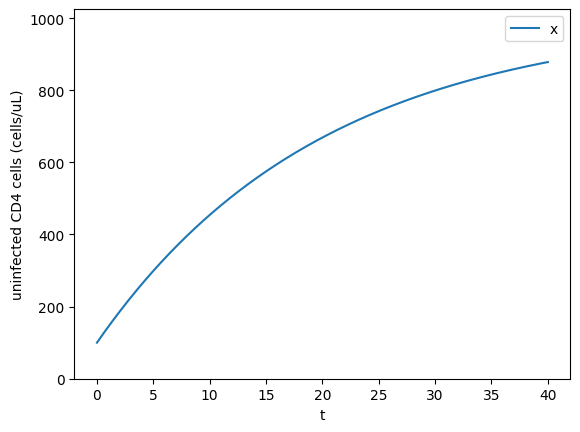

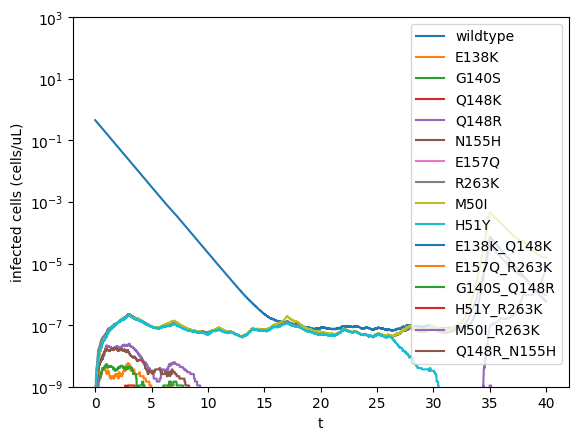

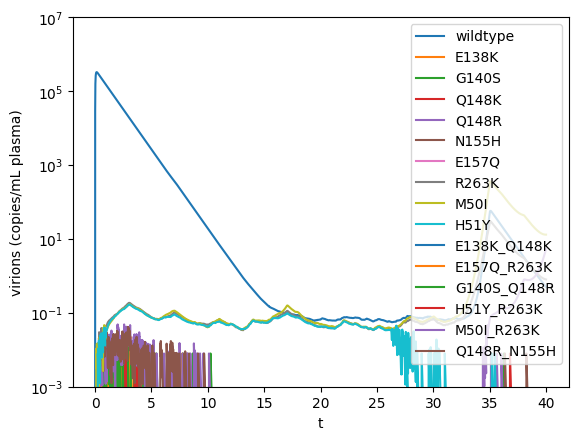

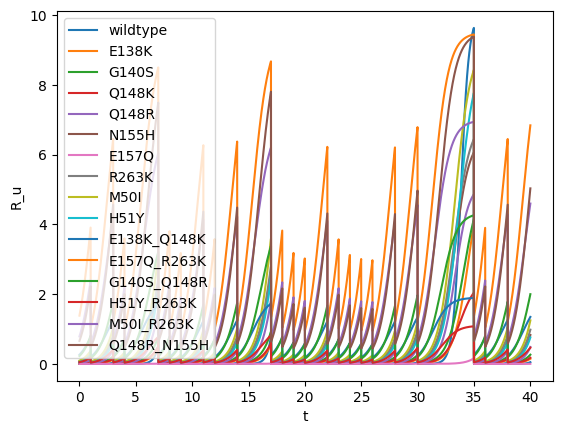

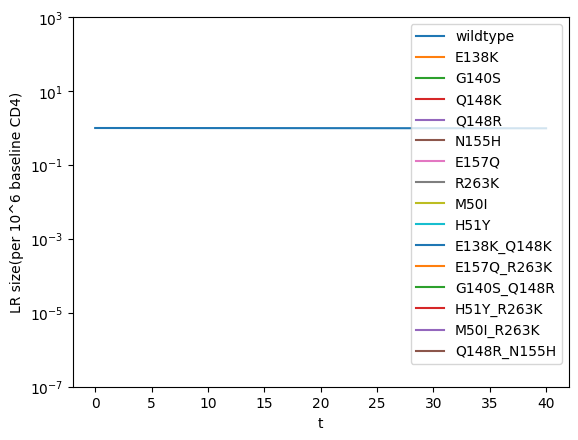

In [34]:
mnames = list(np.asarray(eng.eval('mparams.Properties.RowNames')))

import matplotlib.pyplot as plt
plt.figure()
plt.plot(result.t_history, result.y_history[0].T/scale_cd4_body, label='x')
plt.yscale('linear')
plt.ylabel('uninfected CD4 cells (cells/uL)')
plt.xlabel('t')
plt.legend()
plt.ylim([0, 1025])

plt.figure()
plt.plot(result.t_history, result.y_history[1:1+len(ys)].T/scale_cd4_body, label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('infected cells (cells/uL)')
plt.xlabel('t')
plt.legend()
plt.ylim([1e-9, 1e3])

plt.figure()
plt.plot(result.t_history, result.y_history[model.species.index(vs[0]):model.species.index(vs[-1])+1].T/Vpl/1000, label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('virions (copies/mL plasma)')
plt.xlabel('t')
plt.legend()
plt.ylim([1e-3, 1e7])

plt.figure()
plt.plot(t_vec, beta_t*R00/beta, label=['wildtype']+mnames)
plt.legend()
plt.ylabel('R_u')
plt.xlabel('t')
plt.yscale('linear')

plt.figure()
plt.plot(result.t_history, result.y_history[model.species.index(zs[0]):model.species.index(zs[-1])+1].T*(10**6)/(L/dx), label=['wildtype']+mnames)
plt.yscale('log')
plt.ylabel('LR size(per 10^6 baseline CD4)')
plt.xlabel('t')
plt.legend()
plt.ylim([1e-7, 10e2])

In [31]:
result.y_history[model.species.index(zs[0]):model.species.index(zs[-1])+1][:,-1]/(10**6)/(L/dx)

array([9.81577558e-13, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])